<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 3. Redes Neuronales Recurrentes

In [1]:
! pip install -q torchtext

In [100]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torchmetrics
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_data():
    # Archivo demasiado grande (probablemente no entre en RAM)
    reader =  csv.reader(open("alvaro/data/sentiment140/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))
    # reader =  csv.reader(open("data/sentiment140/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))
    data = []
    for each_line in reader:
        data.append((each_line[-1], int(each_line[0] == '4')))
        
    return data

In [4]:
# data es una lista de tuplas (tweet [str], valor [int])
data = get_data()
# El tokenizador separa las oraciones en secuencias de palabras
tokenizer = torchtext.data.get_tokenizer('basic_english')
# Convertir a minúsculas y eliminar marcas de puntuación
data_list = [(' '.join(token for token in tokenizer(each[0].lower()) \
                       if token not in punctuation), each[1]) for each in data]

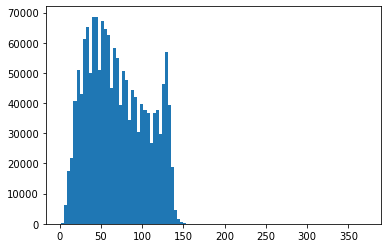

In [5]:
# Histogram por longitud de tweet
x = [len(each[0]) for each in data_list]
plot = plt.hist(x, bins=100)

In [6]:
(torch.Tensor(x) > 140).sum()

tensor(4777)

In [7]:
# Cargamos la herramienta GloVe para crear los embeddings de las palabras
glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [8]:
# Minimum frequency to appear in vocab
min_freq = 10
# Counter counts word repetitions
counter = Counter()
# specials = ['<unk>', '<BOS>', '<EOS>', '<PAD>']
specials = ['<unk>', '<PAD>']
for each in specials:
    counter.update([each])
    counter[each] = min_freq
for (line, label) in data_list:
    counter.update(tokenizer(line))
vocab = torchtext.vocab.vocab(dict(counter), min_freq=10)
# Set index for OOV (Out Of Vocabulary) token occurs
vocab.set_default_index(0)

In [9]:
# Transform words into ints
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
data_preprocessed = [(torch.tensor(text_transform(each[0])),
                      torch.tensor(each[1])) \
                     for each in data_list]

In [10]:
# Original
print(data[80000])
# Normalized text
print(data_list[80000])
# Tokenized text (int)
print(data_preprocessed[80000])

('Cannot actually keep my eyes open.., I feel like shit ', 0)
('cannot actually keep my eyes open i feel like shit', 0)
(tensor([2510,  606,  809,   55,  239, 1529,   42,  285,   60,  981]), tensor(0))


In [11]:
random.seed(8080)
random.shuffle(data_preprocessed)
data_length = len(data_preprocessed)
train_list, test_list = torch.utils.data.random_split(data_preprocessed, 
                              [int(data_length*0.75),
                              int(data_length*0.25)], 
                              generator=torch.manual_seed(4040))
# train_list, test_list, _ = torch.utils.data.random_split(data_preprocessed, 
#                               [10000, 5000, int(len(data_preprocessed)-15000)], 
#                               generator=torch.manual_seed(4040))

In [12]:
input_size = 50
hidden_size = 60
n_classes = 1
batch_size = 1024
lr = 0.001
epochs = 20

## Redes Neuronales Recurrentes (RNN)

In [106]:
# Sigmoid is no longer needed if loss=BCEWithLogitsLoss
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
        self.emb = nn.Embedding(400000, 50)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
#         self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        print(x.shape)
        # Forward propagate the RNN
        out, last_hidden = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
#         out = self.sigmoid(out)
        return out

In [107]:
# Pad sentences from batch to the longest sentence 
def collate_batch(batch):
    x, y = map(list, zip(*batch))
    return torch.nn.utils.rnn.pad_sequence(x, padding_value=3, batch_first=True), torch.tensor(y)

In [108]:
# Sample batch indices from pool of similar lengths
def batch_sampler(data_list):
    indices = [(i, len(s[0])) for i, s in enumerate(data_list)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of batch_size*100 indices with similar lengths 
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i:i + batch_size]

In [109]:
train_dataloader = torch.utils.data.DataLoader(train_list, collate_fn=collate_batch,
                                               batch_sampler=batch_sampler(train_list))
test_dataloader = torch.utils.data.DataLoader(test_list, collate_fn=collate_batch,
                                              batch_sampler=batch_sampler(test_list))

In [110]:
model = RNN(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes).to(device)

In [111]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)

In [112]:
next(model.parameters()).is_cuda

True

In [113]:
def train(model, dataloader, device, optimizer, loss_fn):
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds.squeeze(1), y.float())
        loss.backward()
        optimizer.step()

In [114]:
def test(model, dataloader, device, loss_fn, metrics_fn=None):
    loss_total = 0.0
    model.eval()
    metrics_fn.reset()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = loss_fn(preds.squeeze(1), y.float())
            metrics = metrics_fn(torch.sigmoid(preds.squeeze(1)), y)
            loss_total += loss
        metrics = metrics_fn.compute()
        return loss_total, metrics

In [22]:
for epoch in range(1, 10):
    t1 = time.time()
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)
    t2 = time.time()
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_accuracy = test(model, train_dataloader, device, loss_fn, metrics_fn)
    t3 = time.time()
    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(train_loss, train_accuracy*100))

    t4 = time.time()
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_accuracy = test(model, test_dataloader, device, loss_fn, metrics_fn) 
    t5 = time.time()
    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy*100))
    print('Time elapsed - Training: {:.2f}, test train: {:.2f}, test test: {:.2f}'.format(t2-t1, t3-t2, t5-t4))


Epoch 1
Training Loss: 557.2955, Training Accuracy: 78.74%
Test Loss: 188.1170, Test Accuracy: 78.14%
Time elapsed - Training: 10.60, test train: 5.94, test test: 1.94

Epoch 2
Training Loss: 520.9472, Training Accuracy: 80.41%
Test Loss: 178.1470, Test Accuracy: 79.44%
Time elapsed - Training: 10.57, test train: 5.92, test test: 1.92


KeyboardInterrupt: ignored